In [103]:
import pandas as pd
import numpy as np
import pickle
from pandas import ExcelWriter
import ffn
%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

#pull in data from AlphaVantage
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='NXY0VT9AHBRYGKKC',output_format='pandas')

In [104]:
def historical_data(ticker, outsize = "full"):
    #outsize can be compact and full. 
    #compact returns only the latest 100 data points; full 
    #returns the full-length time series of up to 20 years of historical data. The "compact" option is 
    #recommended if you would like to reduce the data size of each API call
    alphavantage_link = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={0}&apikey=NXY0VT9AHBRYGKKC&datatype=csv&outputsize={1}'.format(ticker, outsize)
    df = pd.read_csv(alphavantage_link)
    return df

In [105]:
VAA = ['AGG', 'EFA', 'EEM','LQD','IEF','SHY']
Maindf = historical_data("SPY")
Maindf.index = pd.to_datetime(Maindf.timestamp) #set the index as the timestamp
#Maindf.index = pd.to_datetime(Maindf.index) #make the index datetime
Maindf = Maindf[['timestamp','close']]
Maindf.columns = ["timestamp","SPY"]

In [106]:
for ticker in VAA:
    temp_df = historical_data(ticker)
    temp_df.index = pd.to_datetime(temp_df.timestamp) #set the index as the timestamp
    temp_df = temp_df[['close']]
    temp_df.columns = [ticker]
    Maindf = Maindf.join(temp_df, how = "left")

Maindf.dropna(inplace = True)
Maindf = Maindf.sort_index()

In [107]:
Maindf = Maindf.sort_index()

In [108]:
Maindf['Year'] = Maindf.index.year
Maindf['Month'] = Maindf.index.month
Maindf['Day'] = Maindf.index.day
Maindf['Month Change'] = Maindf['Month'] - Maindf['Month'].shift(-1) #shift -1 moves row up 

In [109]:
Maindf.head(10)

,timestamp,SPY,AGG,EFA,EEM,LQD,IEF,SHY,Year,Month,Day,Month Change
timestamp,,,,,,,,,,,,
2003-09-26,2003-09-26,99.95,102.45,117.00,135.40,111.85,86.13,82.60,2003,9,26,0.0
2003-09-29,2003-09-29,100.93,102.17,118.50,136.36,111.55,85.76,82.56,2003,9,29,0.0
2003-09-30,2003-09-30,99.95,102.70,117.00,135.93,112.29,86.59,82.73,2003,9,30,-1.0
2003-10-01,2003-10-01,102.08,102.65,120.84,139.50,111.88,86.24,82.65,2003,10,1,0.0
2003-10-02,2003-10-02,102.45,102.49,120.65,141.50,111.45,85.93,82.65,2003,10,2,0.0
2003-10-03,2003-10-03,103.39,101.75,122.41,142.90,109.90,84.74,82.44,2003,10,3,0.0
2003-10-06,2003-10-06,103.86,101.90,123.69,143.45,110.01,84.99,82.50,2003,10,6,0.0
2003-10-07,2003-10-07,104.26,101.55,123.50,143.30,109.64,84.50,82.42,2003,10,7,0.0
2003-10-08,2003-10-08,104.00,101.80,122.99,144.37,110.04,84.65,82.42,2003,10,8,0.0


In [110]:
Maindf_EOM = Maindf[Maindf['Month Change'] != 0]
Maindf_EOM = Maindf_EOM[['SPY','AGG','EFA','EEM','LQD','IEF','SHY']]

In [111]:
Maindf_EOM_VAA = Maindf_EOM.pct_change(12) + 2 * Maindf_EOM.pct_change(6) + 4 * Maindf_EOM.pct_change(3) + 12 * Maindf_EOM.pct_change(1)

In [112]:
Maindf_EOM_VAA.tail(3)

,SPY,AGG,EFA,EEM,LQD,IEF,SHY
timestamp,,,,,,,
2018-04-30,-0.016480,-0.310711,0.155278,-0.461291,-0.512819,-0.365218,-0.098303
2018-05-31,0.448191,-0.037642,-0.246528,-0.417471,-0.151303,0.003708,0.000828
2018-06-19,0.565365,-0.185228,-0.509293,-0.915219,-0.364928,-0.190390,-0.069247


In [113]:
Maindf_EOM_VAA['Indicator'] = np.where(Maindf_EOM_VAA[['SPY','AGG','EFA','EEM']].min(axis = 1) > 0, Maindf_EOM_VAA[['SPY','AGG','EFA','EEM']].idxmax(axis = 1), Maindf_EOM_VAA[['LQD','IEF','SHY']].idxmax(axis = 1))

In [114]:
Maindf_EOM_VAA.tail(10)

,SPY,AGG,EFA,EEM,LQD,IEF,SHY,Indicator
timestamp,,,,,,,,
2017-09-29,0.630242,-0.095409,0.841509,0.796887,0.026885,-0.224357,-0.043081,LQD
2017-10-31,0.821054,-0.032121,0.749895,1.176776,0.029542,-0.110077,-0.049771,LQD
2017-11-30,1.047712,-0.096997,0.631815,0.603100,-0.037711,-0.171872,-0.086394,LQD
2017-12-29,0.733749,0.026478,0.515784,1.094493,0.154199,-0.062788,-0.077804,EEM
2018-01-31,1.584975,-0.215090,1.289112,2.103068,-0.176415,-0.448897,-0.101025,SHY
2018-02-28,0.007909,-0.317373,-0.305730,-0.134892,-0.506558,-0.409951,-0.095022,SHY
2018-03-29,-0.219928,-0.076286,0.017090,0.544013,-0.172176,-0.055630,-0.029012,SHY
2018-04-30,-0.016480,-0.310711,0.155278,-0.461291,-0.512819,-0.365218,-0.098303,SHY
2018-05-31,0.448191,-0.037642,-0.246528,-0.417471,-0.151303,0.003708,0.000828,IEF


In [115]:
Maindf_EOM_VAA.columns = ['SPY_MOMP','AGG_MOMP','EFA_MOMP','EEM_MOMP','LQD_MOMP','IEF_MOMP','SHY_MOMP','indicator']

In [116]:
Maindf_Merged = Maindf_EOM.join(Maindf_EOM_VAA, how = "left").dropna()

In [117]:
Maindf_Daily = Maindf[['SPY','AGG','EFA','EEM','LQD','IEF','SHY']]
Maindf_Daily_MOMP = Maindf_Daily.pct_change(252) + 2 * Maindf_Daily.pct_change(132) + 4 * Maindf_Daily.pct_change(66) + 12 * Maindf_Daily.pct_change(22)
Maindf_Daily_MOMP['Indicator Daily'] = np.where(Maindf_Daily_MOMP[['SPY','AGG','EFA','EEM']].min(axis = 1) > 0, Maindf_Daily_MOMP[['SPY','AGG','EFA','EEM']].idxmax(axis = 1), Maindf_Daily_MOMP[['LQD','IEF','SHY']].idxmax(axis = 1))



In [118]:
test = Maindf_Daily.join(Maindf_EOM_VAA, how = "left")

In [124]:
test['indicator_new'] = test.indicator.ffill()

In [134]:
df = test[['SPY','AGG','EFA','EEM','LQD','IEF','SHY','indicator_new']].dropna()

In [144]:
df['VAA_Prices'] = df.lookup(df.index, df.indicator_new)
df['VAA_Log'] = df.VAA_Prices.to_log_returns()

In [153]:
df.dropna(inplace = True)
df['VAA_Log_New'] = np.where(df.indicator_new != df.indicator_new.shift(1), 0, df.VAA_Log)

In [154]:
df

,SPY,AGG,EFA,EEM,LQD,IEF,SHY,indicator_new,something,VAA_Prices,VAA_Log,VAA_Log_New
timestamp,,,,,,,,,,,,
2004-10-01,113.65,102.170,143.60,175.800,110.840,85.2800,81.850,EEM,175.800,175.800,0.018950,0.000000
2004-10-04,113.84,102.200,143.82,178.800,110.770,85.3100,81.860,EEM,178.800,178.800,0.016921,0.016921
2004-10-05,113.90,102.190,143.90,177.480,111.230,85.3100,81.870,EEM,177.480,177.480,-0.007410,-0.007410
2004-10-06,114.62,102.000,144.44,179.530,110.910,85.0300,81.800,EEM,179.530,179.530,0.011484,0.011484
2004-10-07,113.45,102.000,143.45,178.000,110.670,84.8800,81.770,EEM,178.000,178.000,-0.008559,-0.008559
2004-10-08,112.51,102.500,144.45,176.700,111.750,85.6000,81.980,EEM,176.700,176.700,-0.007330,-0.007330
2004-10-11,112.97,102.600,144.80,177.620,111.850,85.7400,82.040,EEM,177.620,177.620,0.005193,0.005193
2004-10-12,112.53,102.500,143.15,174.820,111.910,85.7400,82.060,EEM,174.820,174.820,-0.015890,-0.015890
2004-10-13,111.54,102.650,142.15,172.450,112.340,86.0500,82.120,EEM,172.450,172.450,-0.013650,-0.013650


In [155]:
#df.to_csv('test.csv')

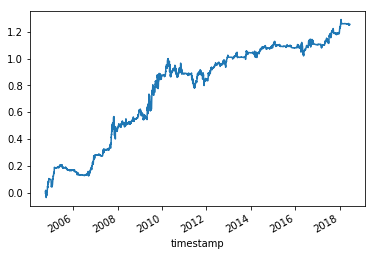

In [160]:
df.VAA_Log_New.cumsum().plot()

In [ ]:
save_xls([Maindf_EOM,Maindf_EOM_VAA,Maindf,Maindf_Merged,Maindf_Daily_MOMP],"H:\\vaa.xlsx",["PRICES END OF MONTH","MOMP","RAW PRICES","MERGED_DF","Maindf_Daily_MOMP"])

In [ ]:
with open('filename.pickle', 'wb') as handle:
    pickle.dump(Maindf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
test = Maindf[['SPY','AGG','EFA','EEM']]

In [ ]:
perf = test.calc_stats()

In [ ]:
perf.display()

In [ ]:
perf.stats

In [ ]:
perf.stats.loc['cagr']

In [ ]:
returns = test.to_log_returns().dropna()
 
print(returns.head())

In [ ]:
ax = returns.hist(figsize=(20, 10),bins=30)

In [ ]:
returns.corr().as_format('.2f')

In [ ]:
returns.plot_corr_heatmap()

In [ ]:
ffn.to_drawdown_series(test).plot(figsize=(15,10))